In [505]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import re
import multiprocessing
from collections import Counter
import itertools
import json
from IPython.display import display as disp
import pickle
from importlib import reload as libreload

import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
# import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (0.400, 0.400, 0.400),
              (0.941, 0.008, 0.498),
              (1.000, 1.000, 0.600)]
%matplotlib inline
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]
mpl.rcParams['text.usetex'] = True

from sklearn import metrics
from sklearn import svm

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, graph, plotting

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

# import pixiedust



In [10]:
!/lscr_paper/allan/bin_allan/exa -l --header gender*.pkl

Permissions Size User   Date Modified Name
.rw-rw-r--  499k bzg778 17 Nov  1:53  gender_prediction_svm_lin_kernel_auc_score.pkl
.rw-rw-r--  644k bzg778 17 Nov  1:53  gender_prediction_svm_poly_kernel_auc_score.pkl
.rw-rw-r--  733k bzg778 17 Nov  1:54  gender_prediction_svm_rbf_kernel_auc_score.pkl


In [31]:
def read_result_pickle(pkl):
    with open(pkl, 'br') as fid:
        est = pickle.load(fid)
    svc = est.best_estimator_
    return est, svc

In [42]:
est_lin, svc_lin = read_result_pickle('gender_prediction_svm_lin_kernel_auc_score.pkl') 
est_poly, svc_poly = read_result_pickle('gender_prediction_svm_poly_kernel_auc_score.pkl') 
est_rbf, svc_rbf = read_result_pickle('gender_prediction_svm_rbf_kernel_auc_score.pkl') 

Print the results from the AUC validation data and _all_ data to a LaTeX table

In [92]:
auc_dct = {
'lin.best_auc': est_lin.best_auc_,
'lin.best_auc_full': est_lin.best_auc_full_,
'poly.best_auc': est_poly.best_auc_,
'poly.best_auc_full': est_poly.best_auc_full_,
'rbf.best_auc': est_rbf.best_auc_,
'rbf.best_auc_full': est_rbf.best_auc_full_
} 

print(pd.Series(auc_dct).rename(index=lambda s: s.replace('.', '_')).to_latex(float_format="%.3f")) 

\begin{tabular}{lr}
\toprule
{} &     0 \\
\midrule
lin\_best\_auc       & 0.784 \\
lin\_best\_auc\_full  & 0.843 \\
poly\_best\_auc      & 0.771 \\
poly\_best\_auc\_full & 0.931 \\
rbf\_best\_auc       & 0.766 \\
rbf\_best\_auc\_full  & 0.936 \\
\bottomrule
\end{tabular}



# Examine the linear kernel SVM CV results

In [411]:
dfl = pd.DataFrame(est_lin.cv_results_)
dfl.loc[dfl.param_svc__class_weight.isna(), 'param_svc__class_weight'] = 'unbalanced'
dfl['param_svc__class_weight'] = dfl['param_svc__class_weight'].str.title() 
dfl.head() 

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_svc__C,...,split6_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.206421,0.008056,0.808324,0.840118,0.000244141,...,0.842990,0.015751,0.001378,0.060672,0.006683
1,0.121860,0.004603,0.816381,0.858514,0.000244141,...,0.859600,0.018933,0.000672,0.054372,0.008244
2,0.273839,0.007744,0.809152,0.841711,0.000488281,...,0.844853,0.063384,0.000575,0.059790,0.007334
3,0.213579,0.005122,0.817701,0.858581,0.000488281,...,0.859667,0.044558,0.000460,0.053850,0.008166
4,0.303253,0.007517,0.814055,0.847644,0.000976562,...,0.849344,0.059478,0.002366,0.060522,0.007802


In [412]:
print("Best params for SVC:\n", *svc_lin.named_steps['svc'].get_params().items(), sep='\n') 

Best params for SVC:

('C', 0.00048828125)
('cache_size', 200)
('class_weight', None)
('coef0', 0.0)
('decision_function_shape', 'ovr')
('degree', 3)
('gamma', 'auto')
('kernel', 'linear')
('max_iter', -1)
('probability', True)
('random_state', None)
('shrinking', True)
('tol', 0.001)
('verbose', False)


In [413]:
print(*dfl.columns, sep='\n')

mean_fit_time
mean_score_time
mean_test_score
mean_train_score
param_svc__C
param_svc__class_weight
params
rank_test_score
split0_test_score
split0_train_score
split1_test_score
split1_train_score
split2_test_score
split2_train_score
split3_test_score
split3_train_score
split4_test_score
split4_train_score
split5_test_score
split5_train_score
split6_test_score
split6_train_score
std_fit_time
std_score_time
std_test_score
std_train_score


#### Plot AUC scores

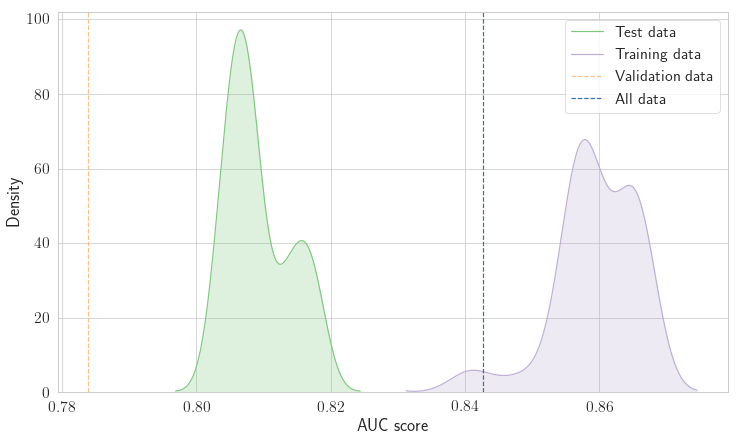

In [414]:
fig, ax = plt.subplots()
sns.kdeplot(dfl.mean_test_score, shade=True, label="Test data", ax=ax)
sns.kdeplot(dfl.mean_train_score, shade=True, label="Training data", ax=ax)
ax.set_xlabel("AUC score")
ax.set_ylabel("Density")
ylim = ax.get_ylim()
ax.plot([est_lin.best_auc_, est_lin.best_auc_], ylim, '--', label="Validation data")
ax.plot([est_lin.best_auc_full_, est_lin.best_auc_full_], ylim, '--', label="All data")
ax.set_ylim(ylim)
ax.legend() 

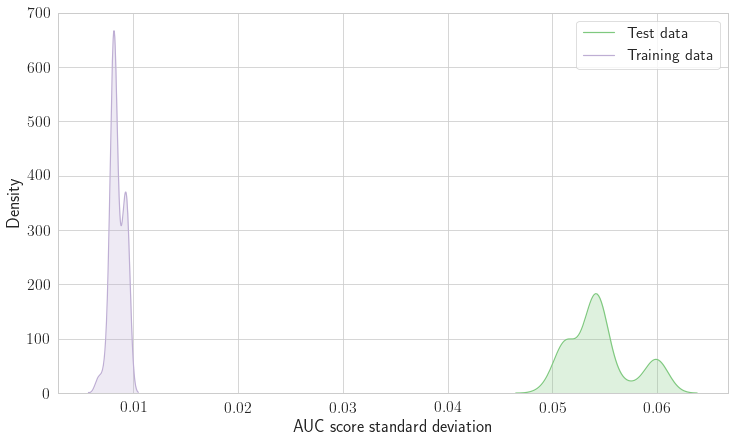

In [415]:
fig, ax = plt.subplots()
sns.kdeplot(dfl.std_test_score, shade=True, label="Test data", ax=ax)
sns.kdeplot(dfl.std_train_score, shade=True, label="Training data", ax=ax)
ax.set_xlabel("AUC score standard deviation")
ax.set_ylabel("Density")
ax.legend() 

#### Mean test score vs class weights

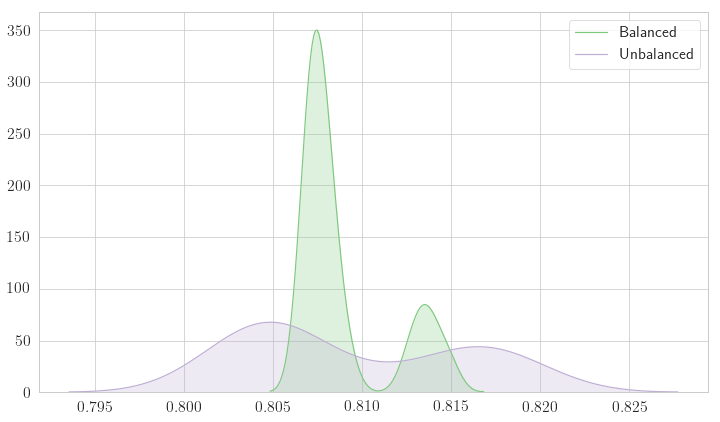

In [416]:
fig, ax = plt.subplots()
lbl0, dat0 = list(dfl.groupby('param_svc__class_weight').mean_test_score )[0]
lbl1, dat1 = list(dfl.groupby('param_svc__class_weight').mean_test_score )[1] 
sns.kdeplot(dat0, label=lbl0, ax=ax, shade=True)
sns.kdeplot(dat1, label=lbl1, ax=ax, shade=True)

#### Mean test score vs C

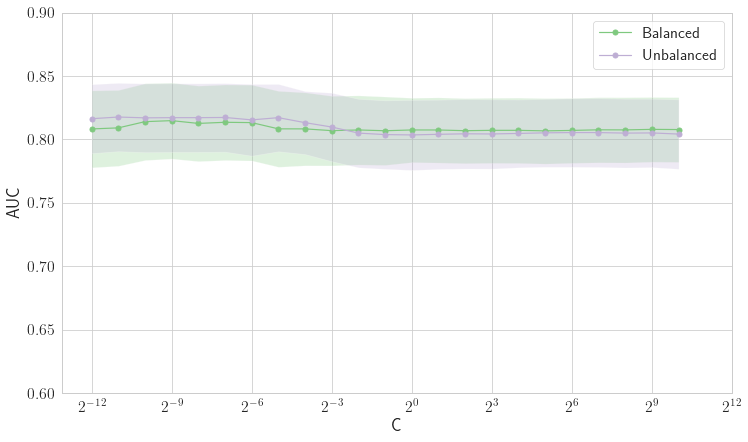

In [599]:
C_AUC_mean = dfl.groupby(['param_svc__class_weight', 'param_svc__C']).mean_test_score.sum() 
C_AUC_std = dfl.groupby(['param_svc__class_weight', 'param_svc__C']).std_test_score.sum() 

fig, ax = plt.subplots()
alpha = 0.25
ax.set_xscale('log')

# Plot std shading for balanced
xx = C_AUC_std.loc['Balanced'].index
yy_upper = C_AUC_mean['Balanced'] + C_AUC_std['Balanced']/2
yy_lower = C_AUC_mean['Balanced'] - C_AUC_std['Balanced']/2
ax.fill_between(xx, yy_lower, yy_upper, alpha=alpha)

# Plot std shading for unbalanced
yy_upper = C_AUC_mean['Unbalanced'] + C_AUC_std['Unbalanced']/2
yy_lower = C_AUC_mean['Unbalanced'] - C_AUC_std['Unbalanced']/2
ax.fill_between(xx, yy_lower, yy_upper, alpha=alpha) 

# Plot mean test score
C_AUC_mean.loc['Balanced'].plot(ax=ax, style='.-', markersize=10, label="Balanced")
C_AUC_mean.loc['Unbalanced'].plot(ax=ax, style='.-', markersize=10, label="Unbalanced")  

ax.legend() 
ax.set_xlabel("C")
ax.set_ylabel("AUC")

# Set axis properties
ax.set_ylim([0.6, 0.9])
stride = 3
ax.set_xticks([2.0**i for i in range(-12, 13, stride)])
ax.set_xticklabels(["$2^{%d}$" % i for i in range(-12, 13, stride)]);

# Examine the Poly results

In [558]:
dfp = pd.DataFrame(est_poly.cv_results_)
dfp.loc[dfp.param_svc__class_weight.isna(), 'param_svc__class_weight'] = 'unbalanced'
dfp['param_svc__class_weight'] = dfp['param_svc__class_weight'].str.title() 
dfp.head() 

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_svc__C,...,split6_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.172363,0.007414,0.581074,0.821564,0.000244141,...,0.820026,0.031813,0.001286,0.033004,0.016954
1,0.219988,0.008369,0.781835,0.918690,0.000244141,...,0.920865,0.013101,0.000458,0.047406,0.002962
2,0.219838,0.007679,0.577059,0.944866,0.000244141,...,0.941376,0.024121,0.000953,0.028083,0.009791
3,0.205205,0.007903,0.735114,0.964127,0.000244141,...,0.964005,0.010124,0.000304,0.046406,0.002950
4,0.119693,0.005332,0.577048,0.844571,0.000244141,...,0.840094,0.025655,0.000429,0.076918,0.009436


In [559]:
print("Best params for SVC:\n", *svc_poly.named_steps['svc'].get_params().items(), sep='\n') 

Best params for SVC:

('C', 0.25)
('cache_size', 200)
('class_weight', 'balanced')
('coef0', 0.0)
('decision_function_shape', 'ovr')
('degree', 3)
('gamma', 'auto')
('kernel', 'poly')
('max_iter', -1)
('probability', True)
('random_state', None)
('shrinking', True)
('tol', 0.001)
('verbose', False)


In [560]:
print(*dfp.columns, sep='\n')

mean_fit_time
mean_score_time
mean_test_score
mean_train_score
param_svc__C
param_svc__class_weight
param_svc__degree
params
rank_test_score
split0_test_score
split0_train_score
split1_test_score
split1_train_score
split2_test_score
split2_train_score
split3_test_score
split3_train_score
split4_test_score
split4_train_score
split5_test_score
split5_train_score
split6_test_score
split6_train_score
std_fit_time
std_score_time
std_test_score
std_train_score


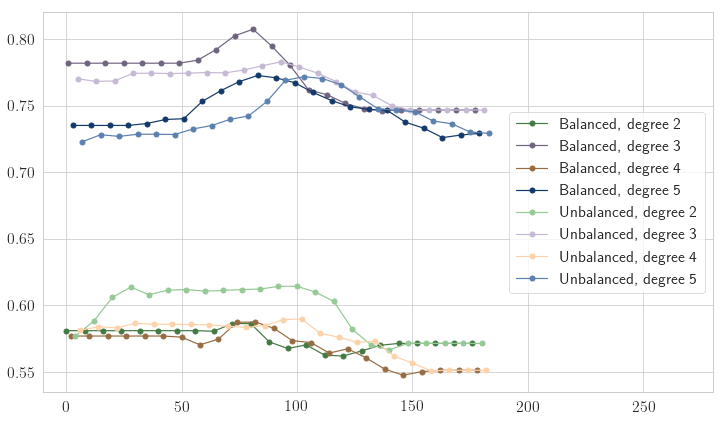

In [561]:
# Temporarily modify color cycle
lst0, lst1 = list(), list()
for i in range(4):
    rgb = colorcycle[i]
    lst0.append(plotting.rgb_hsv_modify(rgb, v=0.6, s=1.2))
    lst1.append(plotting.rgb_hsv_modify(rgb, s=0.7))
collst = list() + lst0 + lst1 + colorcycle[4:]

sns.set_palette(collst)
fig, ax = plt.subplots()
grp = dfp.groupby(['param_svc__class_weight', 'param_svc__degree']) 
grp.mean_test_score.plot(style='.-', markersize=10, ax=ax) 

ax.set_xlim([-10, 280])

_, legend_texts = ax.get_legend_handles_labels() 
legend_texts = [el.replace('(', '').replace(')', '').replace(', ', ', degree ') for el in legend_texts]
ax.legend(legend_texts, loc="center right")

# sns.set_palette(colorcycle)

Degree 3 and 5 seems most promising, drop 2, and 4 from the datsaset

In [562]:
dfp = dfp.loc[dfp.param_svc__degree.isin([3, 5])]

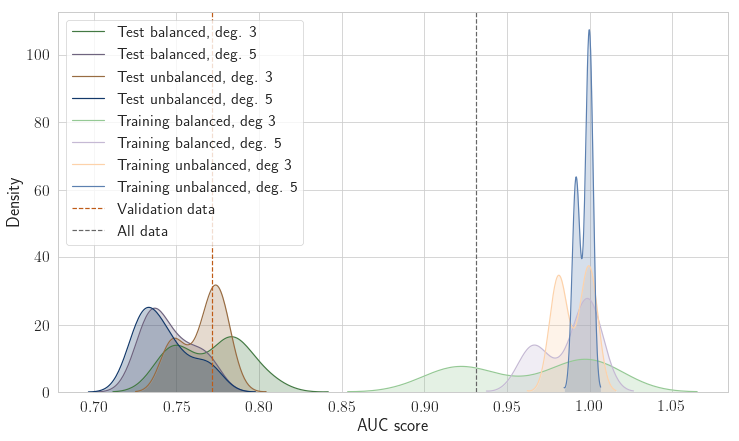

In [563]:
fig, ax = plt.subplots()
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==3) & (dfp.param_svc__class_weight=='Balanced'), 'mean_test_score'], shade=True, label="Test balanced, deg. 3", ax=ax)
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==5) & (dfp.param_svc__class_weight=='Balanced'), 'mean_test_score'], shade=True, label="Test balanced, deg. 5", ax=ax) 
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==3) & (dfp.param_svc__class_weight=='Unbalanced'), 'mean_test_score'], shade=True, label="Test unbalanced, deg. 3", ax=ax)
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==5) & (dfp.param_svc__class_weight=='Unbalanced'), 'mean_test_score'], shade=True, label="Test unbalanced, deg. 5", ax=ax) 
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==3) & (dfp.param_svc__class_weight=='Balanced'), 'mean_train_score'], shade=True, label="Training balanced, deg 3", ax=ax)
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==5) & (dfp.param_svc__class_weight=='Balanced'), 'mean_train_score'], shade=True, label="Training balanced, deg. 5", ax=ax)
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==3) & (dfp.param_svc__class_weight=='Unbalanced'), 'mean_train_score'], shade=True, label="Training unbalanced, deg 3", ax=ax)
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==5) & (dfp.param_svc__class_weight=='Unbalanced'), 'mean_train_score'], shade=True, label="Training unbalanced, deg. 5", ax=ax)
ax.set_xlabel("AUC score")
ax.set_ylabel("Density")
ylim = ax.get_ylim()
ax.plot([est_poly.best_auc_, est_poly.best_auc_], ylim, '--', label="Validation data")
ax.plot([est_poly.best_auc_full_, est_poly.best_auc_full_], ylim, '--', label="All data")
ax.set_ylim(ylim)
lgnd = ax.legend() 

# sns.set_palette(colorcycle)


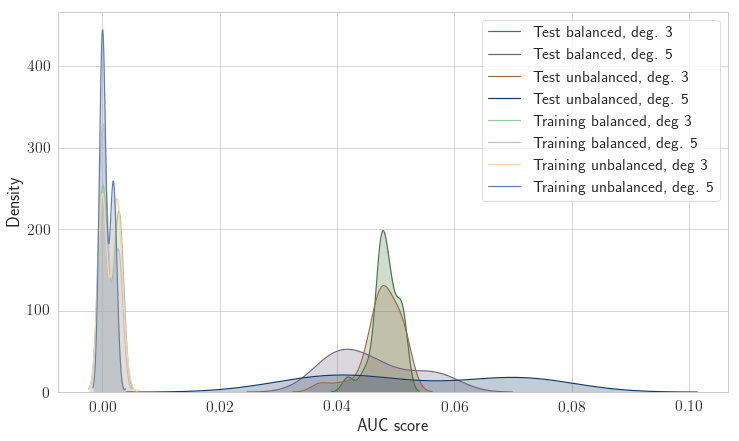

In [564]:
fig, ax = plt.subplots()
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==3) & (dfp.param_svc__class_weight=='Balanced'), 'std_test_score'], shade=True, label="Test balanced, deg. 3", ax=ax)
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==5) & (dfp.param_svc__class_weight=='Balanced'), 'std_test_score'], shade=True, label="Test balanced, deg. 5", ax=ax) 
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==3) & (dfp.param_svc__class_weight=='Unbalanced'), 'std_test_score'], shade=True, label="Test unbalanced, deg. 3", ax=ax)
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==5) & (dfp.param_svc__class_weight=='Unbalanced'), 'std_test_score'], shade=True, label="Test unbalanced, deg. 5", ax=ax) 
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==3) & (dfp.param_svc__class_weight=='Balanced'), 'std_train_score'], shade=True, label="Training balanced, deg 3", ax=ax)
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==5) & (dfp.param_svc__class_weight=='Balanced'), 'std_train_score'], shade=True, label="Training balanced, deg. 5", ax=ax)
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==3) & (dfp.param_svc__class_weight=='Unbalanced'), 'std_train_score'], shade=True, label="Training unbalanced, deg 3", ax=ax)
sns.kdeplot(dfp.loc[(dfp.param_svc__degree==5) & (dfp.param_svc__class_weight=='Unbalanced'), 'std_train_score'], shade=True, label="Training unbalanced, deg. 5", ax=ax)
ax.set_xlabel("AUC score")
ax.set_ylabel("Density")

sns.set_palette(colorcycle)


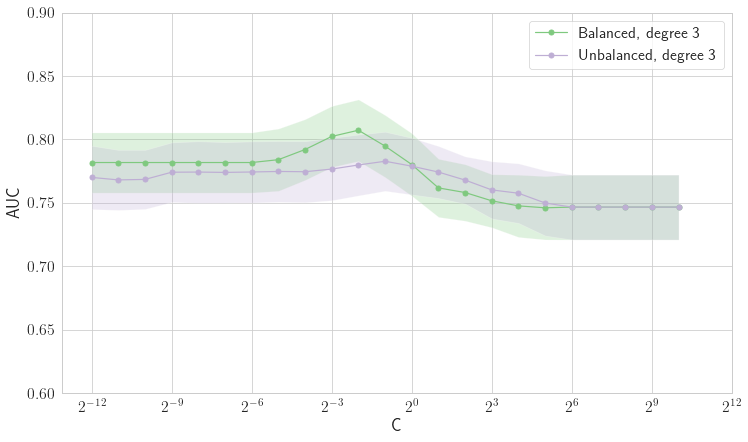

In [598]:
C_AUC_mean_3 = dfp.loc[dfp.param_svc__degree == 3].groupby(['param_svc__class_weight', 'param_svc__C']).mean_test_score.mean()
C_AUC_std_3 = dfp.loc[dfp.param_svc__degree == 3].groupby(['param_svc__class_weight', 'param_svc__C']).std_test_score.mean()


fig, ax = plt.subplots()
alpha = 0.25
ax.set_xscale('log')


# ****************************************************************************
# *                                 Degree 3                                 *
# ****************************************************************************

# Plot std shading for balanced, degree 3
xx = C_AUC_std.loc['Balanced'].index
yy_upper = C_AUC_mean_3['Balanced'] + C_AUC_std_3['Balanced']/2
yy_lower = C_AUC_mean_3['Balanced'] - C_AUC_std_3['Balanced']/2
ax.fill_between(xx, yy_lower, yy_upper, alpha=alpha)

# Plot std shading for unbalanced, degree 3
yy_upper = C_AUC_mean_3['Unbalanced'] + C_AUC_std_3['Unbalanced']/2
yy_lower = C_AUC_mean_3['Unbalanced'] - C_AUC_std_3['Unbalanced']/2
ax.fill_between(xx, yy_lower, yy_upper, alpha=alpha)

# Plot mean test score, degree 3
C_AUC_mean_3.loc['Balanced'].plot(ax=ax, style='.-', markersize=10, label='Balanced, degree 3')
C_AUC_mean_3.loc['Unbalanced'].plot(ax=ax, style='.-', markersize=10, label="Unbalanced, degree 3")



# ****************************************************************************
# *                           Overall plot settings                          *
# ****************************************************************************

ax.legend()
ax.set_xlabel("C")
ax.set_ylabel("AUC")

# Set axis properties
ax.set_ylim([0.6, 0.9])
stride = 3
ax.set_xticks([2.0**i for i in range(-12, 13, stride)])
ax.set_xticklabels(["$2^{%d}$" % i for i in range(-12, 13, stride)]);

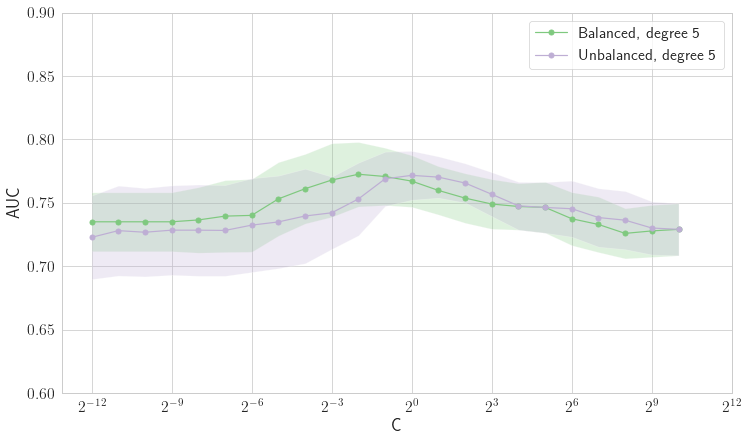

In [597]:
C_AUC_mean_5 = dfp.loc[dfp.param_svc__degree == 5].groupby(['param_svc__class_weight', 'param_svc__C']).mean_test_score.mean()
C_AUC_std_5 = dfp.loc[dfp.param_svc__degree == 5].groupby(['param_svc__class_weight', 'param_svc__C']).std_test_score.mean()


fig, ax = plt.subplots()
alpha = 0.25
ax.set_xscale('log')

# ****************************************************************************
# *                                 Degree 5                                 *
# ****************************************************************************

# Plot std shading for balanced, degree 5
xx = C_AUC_std.loc['Balanced'].index
yy_upper = C_AUC_mean_5['Balanced'] + C_AUC_std_5['Balanced']/2
yy_lower = C_AUC_mean_5['Balanced'] - C_AUC_std_5['Balanced']/2
ax.fill_between(xx, yy_lower, yy_upper, alpha=alpha)

# Plot std shading for unbalanced, degree 5
yy_upper = C_AUC_mean_5['Unbalanced'] + C_AUC_std_5['Unbalanced']/2
yy_lower = C_AUC_mean_5['Unbalanced'] - C_AUC_std_5['Unbalanced']/2
ax.fill_between(xx, yy_lower, yy_upper, alpha=alpha)

# Plot mean test score, degree 5
C_AUC_mean_5.loc['Balanced'].plot(ax=ax, style='.-', markersize=10, label='Balanced, degree 5')
C_AUC_mean_5.loc['Unbalanced'].plot(ax=ax, style='.-', markersize=10, label="Unbalanced, degree 5")

# ****************************************************************************
# *                           Overall plot settings                          *
# ****************************************************************************

ax.legend()
ax.set_xlabel("C")
ax.set_ylabel("AUC")

# Set axis properties
ax.set_ylim([0.6, 0.9])
stride = 3
ax.set_xticks([2.0**i for i in range(-12, 13, stride)])
ax.set_xticklabels(["$2^{%d}$" % i for i in range(-12, 13, stride)]);

# Examine RBF results

In [620]:
dfr = pd.DataFrame(est_rbf.cv_results_)
dfr.loc[dfr.param_svc__class_weight.isna(), 'param_svc__class_weight'] = 'unbalanced'
dfr['param_svc__class_weight'] = dfr['param_svc__class_weight'].str.title() 
dfr.head() 

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_svc__C,...,split6_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.160392,0.006271,0.781835,0.91869,0.000244141,...,0.920865,0.022969,0.000834,0.047406,0.002962
1,0.184596,0.008274,0.781835,0.91869,0.000244141,...,0.920865,0.013684,0.000220,0.047406,0.002962
2,0.199196,0.007864,0.781835,0.91869,0.000244141,...,0.920865,0.011561,0.000536,0.047406,0.002962
3,0.210079,0.009973,0.781835,0.91869,0.000244141,...,0.920865,0.018202,0.005814,0.047406,0.002962
4,0.213989,0.009932,0.781835,0.91869,0.000244141,...,0.920865,0.041865,0.005782,0.047406,0.002962


In [621]:
print("Best params for SVC:\n", *svc_rbf.named_steps['svc'].get_params().items(), sep='\n') 

Best params for SVC:

('C', 0.000244140625)
('cache_size', 200)
('class_weight', 'balanced')
('coef0', 0.0)
('decision_function_shape', 'ovr')
('degree', 3)
('gamma', 0.25)
('kernel', 'poly')
('max_iter', -1)
('probability', True)
('random_state', None)
('shrinking', True)
('tol', 0.001)
('verbose', False)


In [622]:
print(*dfr.columns, sep='\n')

mean_fit_time
mean_score_time
mean_test_score
mean_train_score
param_svc__C
param_svc__class_weight
param_svc__gamma
params
rank_test_score
split0_test_score
split0_train_score
split1_test_score
split1_train_score
split2_test_score
split2_train_score
split3_test_score
split3_train_score
split4_test_score
split4_train_score
split5_test_score
split5_train_score
split6_test_score
split6_train_score
std_fit_time
std_score_time
std_test_score
std_train_score


In [623]:
for k, v in est_rbf.param_grid.items():
    print(k, end=':\n\t')
    print(*v, sep='\n\t')

svc__gamma:
	0.0009765625
	0.001953125
	0.00390625
	0.0078125
	0.015625
	0.03125
	0.0625
	0.125
	0.25
	0.5
	1.0
	2.0
	4.0
svc__C:
	0.000244140625
	0.00048828125
	0.0009765625
	0.001953125
	0.00390625
	0.0078125
	0.015625
	0.03125
	0.0625
	0.125
	0.25
	0.5
	1.0
	2.0
	4.0
	8.0
	16.0
	32.0
	64.0
	128.0
	256.0
	512.0
	1024.0
svc__class_weight:
	balanced
	None


In [637]:
sns.set_palette(colorcycle)

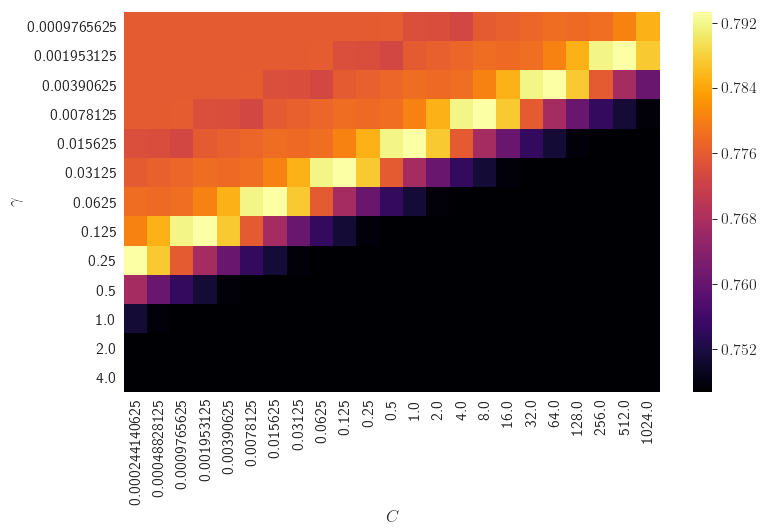

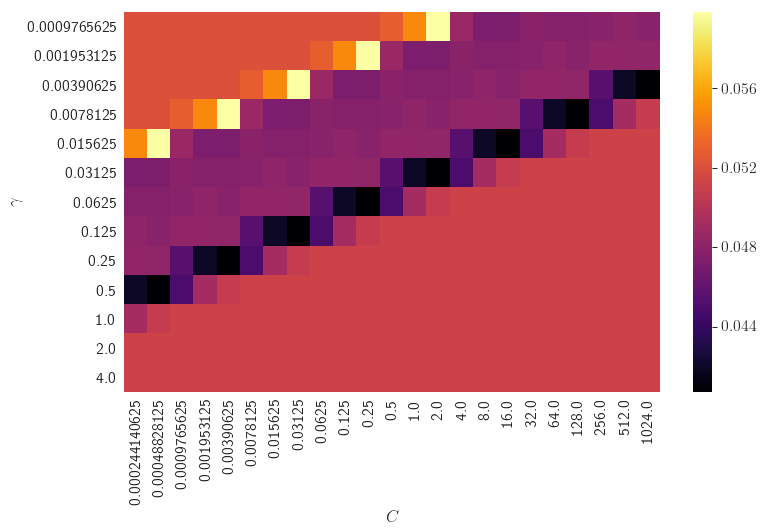

In [651]:
to_plot_mean = dfr.groupby(['param_svc__gamma', 'param_svc__C']).mean_test_score.mean().T.unstack()
to_plot_mean.columns.name = r'$C$'
to_plot_mean.index.name = r'$\gamma$'

fig, ax = plt.subplots()
sns.heatmap(to_plot_mean, cmap='inferno', ax=ax) 



to_plot_std = dfr.groupby(['param_svc__gamma', 'param_svc__C']).std_test_score.mean().T.unstack()
to_plot_std.columns.name = r'$C$'
to_plot_std.index.name = r'$\gamma$'

fig, ax = plt.subplots()
sns.heatmap(to_plot_std, cmap='inferno', ax=ax) 


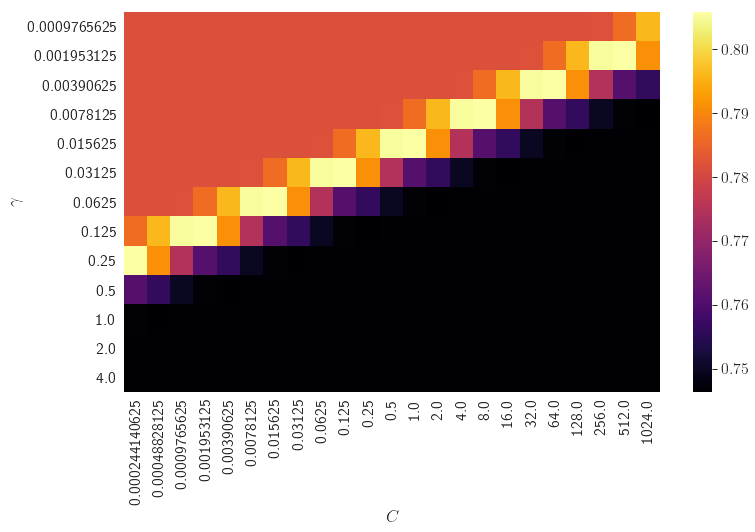

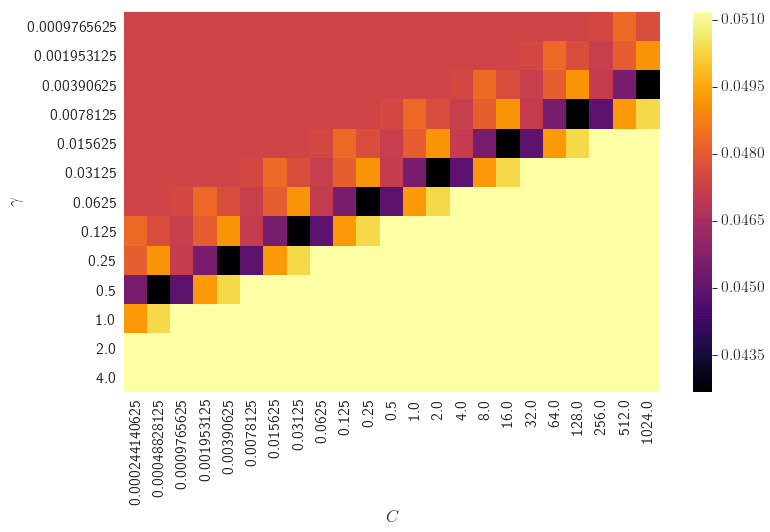

In [649]:
to_plot_mean = dfr[dfr.param_svc__class_weight=='Balanced'].groupby(['param_svc__gamma', 'param_svc__C']).mean_test_score.mean().T.unstack()
to_plot_mean.columns.name = r'$C$'
to_plot_mean.index.name = r'$\gamma$'

fig, ax = plt.subplots()
sns.heatmap(to_plot_mean, cmap='inferno', ax=ax) 



to_plot_std = dfr[dfr.param_svc__class_weight=='Balanced'].groupby(['param_svc__gamma', 'param_svc__C']).std_test_score.mean().T.unstack()
to_plot_std.columns.name = r'$C$'
to_plot_std.index.name = r'$\gamma$'

fig, ax = plt.subplots()
sns.heatmap(to_plot_std, cmap='inferno', ax=ax) 

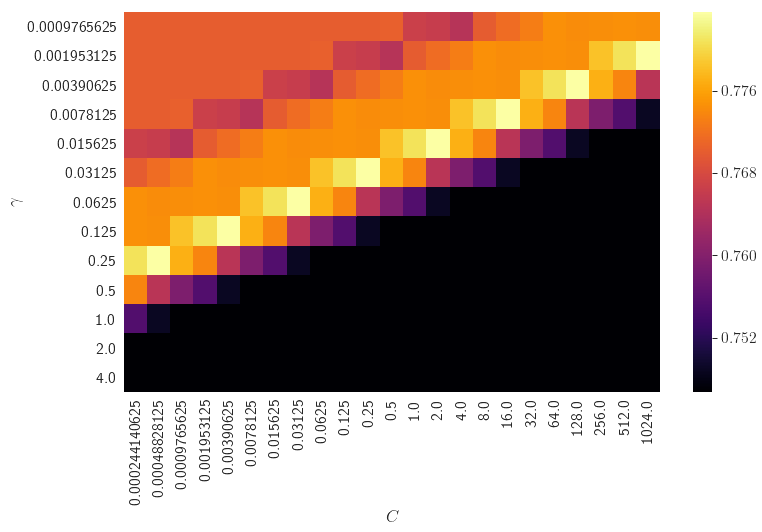

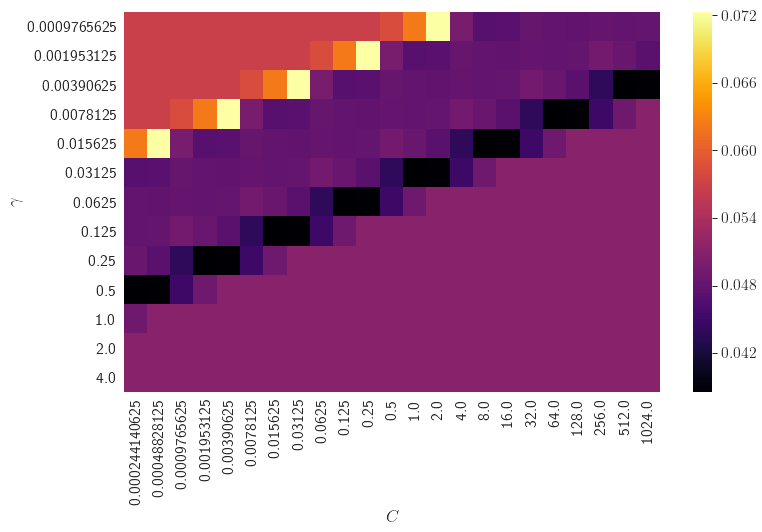

In [650]:
to_plot_mean = dfr[dfr.param_svc__class_weight=='Unbalanced'].groupby(['param_svc__gamma', 'param_svc__C']).mean_test_score.mean().T.unstack()
to_plot_mean.columns.name = r'$C$'
to_plot_mean.index.name = r'$\gamma$'

fig, ax = plt.subplots()
sns.heatmap(to_plot_mean, cmap='inferno', ax=ax) 



to_plot_std = dfr[dfr.param_svc__class_weight=='Unbalanced'].groupby(['param_svc__gamma', 'param_svc__C']).std_test_score.mean().T.unstack()
to_plot_std.columns.name = r'$C$'
to_plot_std.index.name = r'$\gamma$'

fig, ax = plt.subplots()
sns.heatmap(to_plot_std, cmap='inferno', ax=ax) 


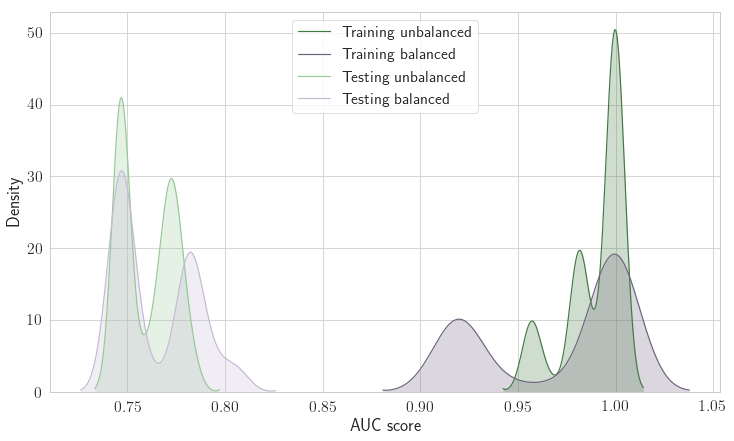

In [658]:
# Temporarily modify color cycle
lst0, lst1 = list(), list()
for i in range(2):
    rgb = colorcycle[i]
    lst0.append(plotting.rgb_hsv_modify(rgb, v=0.6, s=1.2))
    lst1.append(plotting.rgb_hsv_modify(rgb, s=0.7))
collst = list() + lst0 + lst1 + colorcycle[4:] 
sns.set_palette(collst)

fig, ax = plt.subplots()
sns.kdeplot(dfr.loc[dfr.param_svc__class_weight=='Unbalanced', 'mean_train_score'], shade=True, label="Training unbalanced", ax=ax)
sns.kdeplot(dfr.loc[dfr.param_svc__class_weight=='Balanced', 'mean_train_score'], shade=True, label="Training balanced", ax=ax)
sns.kdeplot(dfr.loc[dfr.param_svc__class_weight=='Unbalanced', 'mean_test_score'], shade=True, label="Testing unbalanced", ax=ax)
sns.kdeplot(dfr.loc[dfr.param_svc__class_weight=='Balanced', 'mean_test_score'], shade=True, label="Testing balanced", ax=ax)
ax.set_xlabel("AUC score")
ax.set_ylabel("Density")

sns.set_palette(colorcycle) 

In [674]:
fit_times = pd.DataFrame([dfl.mean_fit_time.describe(), dfr.mean_fit_time.describe(), dfr.mean_fit_time.describe()],
                         index="Linear Polynomial RBF".split()).T
fit_times

,Linear,Polynomial,RBF
count,46.000000,598.000000,598.000000
mean,30.621868,0.208582,0.208582
std,73.994478,0.048583,0.048583
min,0.095862,0.082052,0.082052
25%,0.143633,0.192468,0.192468
50%,0.350011,0.222374,0.222374
75%,12.553065,0.238611,0.238611
max,318.162813,0.312489,0.312489


In [675]:
print(fit_times.to_latex(float_format='%.3f'))

\begin{tabular}{lrrr}
\toprule
{} &  Linear &  Polynomial &     RBF \\
\midrule
count &  46.000 &     598.000 & 598.000 \\
mean  &  30.622 &       0.209 &   0.209 \\
std   &  73.994 &       0.049 &   0.049 \\
min   &   0.096 &       0.082 &   0.082 \\
25\%   &   0.144 &       0.192 &   0.192 \\
50\%   &   0.350 &       0.222 &   0.222 \\
75\%   &  12.553 &       0.239 &   0.239 \\
max   & 318.163 &       0.312 &   0.312 \\
\bottomrule
\end{tabular}

